In [1]:
import pyproj
from  pyproj  import  CRS
from pyproj import Proj
import h5py
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import glob
from netCDF4 import Dataset
import pandas as pd
import gzip
from collections import defaultdict

In [2]:
# 设置空间分辨率
resolution = 10000

# 将WGS 84坐标（4326）转化为等距圆柱投影（4088）
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS.from_epsg(4088)
crs2 = CRS.from_string("epsg:4088")
crs2 = CRS.from_proj4("+proj=latlon")
crs2 = CRS.from_user_input(4088)

transformer = pyproj.Transformer.from_crs(crs,crs2)
transformer_back = pyproj.Transformer.from_crs(crs2,crs)

In [35]:
# 获取数组的长和宽
def get_nlat_nlon_npaeqd(resolution):
    nlat, nlon =40000000/ resolution,40000000/ resolution
    nlat = np.int(nlat)
    nlon = np.int(nlon)
    return nlat, nlon
    
    
def get_nlat_nlon_cyl(resolution):
    nlat, nlon =40000000/ resolution,20000000/ resolution
    nlat = np.int(nlat)
    nlon = np.int(nlon)
    return nlat, nlon

# 获取用来存放数据的grid数组，及其对应的grid_num数组（用来存放一个格子中有多少重合点），以及对应的初始time数组
def get_swh_grid(nlat, nlon):
    swh_grid = np.full(shape=(nlon,nlat), fill_value=np.nan)
    swh_grid_num = np.zeros((nlon,nlat))
    swh_grid_time = np.full(shape=(nlon,nlat), fill_value=np.nan)
    return swh_grid, swh_grid_num, swh_grid_time


def get_nan_grid(nlat, nlon):
    nan_grid = np.full(shape=(nlon,nlat), fill_value=np.nan)
    return nan_grid


def get_num_grid(nlat, nlon):
    num_grid = np.zeros((nlon,nlat))
    return num_grid

# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
def coincident_point_mean(value_array, grid_array, grid_num_array, projlats, projlons):
    for i in range(len(value_array)):
        x = int((projlons[i] )/resolution)
        y = int(projlats[i]/resolution)
        if grid_num_array[x][y] == 0:
            grid_array[x][y] = value_array[i]
            grid_num_array[x][y] += 1
        else:
            grid_array[x][y] += value_array[i]
            grid_num_array[x][y] += 1
    grid_array = grid_array / grid_num_array
    return grid_array

# def coincident_time_log(value_array, grid_array, grid_num_array, grid_time_array, projlats, projlons):
#     time_dict = {}
#     for i in range(len(value_array)):
#         x = int((projlons[i] )/resolution)
#         y = int(projlats[i]/resolution)
#         if grid_num_array[x][y] == 0:
#             hy_grid[x][y] = hy_value_array_masked[i]
#             hy_time_grid[x][y] = hy_time_array[i]
#             dict_name = str(x) + '+' + str(y)
#             hy_time_dict[dict_name] = {hy_time_grid[x][y]: hy_grid[x][y]}
#             grid_num_array[x][y] = 1
        
#         else:
#             dict_name = str(x) + '+' + str(y)
#             hy_time_dict[dict_name][hy_time_array[i]] = hy_value_array_masked[i]
#             grid_num_array[x][y] += 1
        
#     # 删除没有重合点的子字典
#     for key in list(hy_time_dict.keys()):
#         if len(hy_time_dict[key].items()) < 2 :
#             del hy_time_dict[key]

# 处理hy数据

In [4]:
year = 2019
month = 8

# save_output_path = r'.\output\month\2019\05'
hy_dir_path = r'G:\remote_sensing_data\HY-2B\2020\07\20200711'
# hy_dir_path_01 = r'G:\remote_sensing_data\HY-2B\2020\07\20200701_20200711\20200711'
hyfiles = glob.glob(hy_dir_path + '\*.nc')
hy_lon_array = np.array([])
hy_lat_array = np.array([])
hy_time_array = np.array([])
hy_value_array = np.array([])
hy_swhc_mask_array = np.array([])

for hyfile in hyfiles:
    with Dataset(hyfile, mode='r') as fh:
        lons = fh.variables['lon'][:]
        lats = fh.variables['lat'][:]
        swhc = fh.variables['swh_c'][:]
        time = fh.variables['time'][:]
        swhc_mask = swhc.mask
        hy_lon_array = np.append(hy_lon_array, lons)
        hy_lat_array = np.append(hy_lat_array, lats)
        hy_value_array = np.append(hy_value_array, swhc)
        hy_time_array = np.append(hy_time_array, time)
        hy_swhc_mask_array = np.append(hy_swhc_mask_array, swhc_mask)
    hy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)


In [7]:
# 只处理极区
hy_lower_index = []
for i in range(len(hy_value_array)):
    if hy_lat_array[i] > 66 or hy_lat_array[i] < -66 :
        hy_lower_index.append(i)

hy_lat_array = np.delete(hy_lat_array, hy_lower_index)
hy_lon_array = np.delete(hy_lon_array, hy_lower_index)
hy_value_array_masked = np.delete(hy_value_array_masked, hy_lower_index)

In [5]:
hy_projlats,hy_projlons = transformer.transform(hy_lat_array,hy_lon_array)
# 获取东西半球的nlat，nlon，is_grid_west,is_grid_num_west
hy_nlat, hy_nlon =get_nlat_nlon_cyl(resolution)
hy_grid, hy_num_grip, hy_time_grid = get_swh_grid(hy_nlat*2, hy_nlon*2)

In [6]:
hy_time_dict = {}
# hy_grid存储原始值
# hy_time_grid存储原始时间
# 当有两个点在一个格子的时候，用else里面的语句

for i in range(len(hy_value_array_masked)):
    x = int((hy_projlons[i] )/resolution)
    y = int(hy_projlats[i]/resolution)
    if hy_num_grip[x][y] == 0:
        hy_grid[x][y] = hy_value_array_masked[i]
        hy_time_grid[x][y] = hy_time_array[i]
        dict_name = str(x) + '+' + str(y)
        hy_time_dict[dict_name] = {hy_time_grid[x][y]: hy_grid[x][y]}
        hy_num_grip[x][y] = 1
        
    else:
        dict_name = str(x) + '+' + str(y)
        hy_time_dict[dict_name][hy_time_array[i]] = hy_value_array_masked[i]
        hy_num_grip[x][y] += 1

<ipython-input-6-634cf2e4aca7>:6: UserWarning: Warning: converting a masked element to nan.
  hy_grid[x][y] = hy_value_array_masked[i]


In [7]:
# 获取东西半球的nlat，nlon，is_grid_west,is_grid_num_west
_, hy_mean_num_grip, _ = get_swh_grid(hy_nlat*2, hy_nlon*2)

# 交叉点平均化
hy_mean_grid = coincident_point_mean(hy_value_array_masked, hy_grid, hy_mean_num_grip, hy_projlats,hy_projlons)

<ipython-input-3-3b7e03c2948e>:32: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] = value_array[i]
<ipython-input-3-3b7e03c2948e>:35: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] += value_array[i]


# Cryosat 数据处理

In [8]:
# cy_dir_path = r'G:\remote_sensing_data\CRYOSAT-2\2019\05'
cy_dir_path_01 = r"G:\remote_sensing_data\CRYOSAT-2\2020\07\20200711"
cyfiles = glob.glob(cy_dir_path_01 + '\*.nc')
cy_lon_array = np.array([])
cy_lat_array = np.array([])
cy_swh_array = np.array([])
cy_swh_mask_array = np.array([])
cy_time_array = np.array([])

for cyfile in cyfiles:
    with Dataset(cyfile, mode='r') as fh:
        lons = fh.variables['lon_01'][:]
        lats = fh.variables['lat_01'][:]
        swh = fh.variables['swh_ocean_01_ku'][:]
        time = fh.variables['time_cor_01'][:]
        swh_mask = swh.mask
        if np.array(swh_mask,dtype = bool).shape == ():
            swh_mask = np.full((len(swh), ), False)
        cy_lon_array = np.append(cy_lon_array, lons)
        cy_lat_array = np.append(cy_lat_array, lats)
        cy_swh_array = np.append(cy_swh_array, swh)
        cy_swh_mask_array = np.append(cy_swh_mask_array, swh_mask)
        cy_time_array = np.append(cy_time_array, time)
cy_swh_array_masked = np.ma.array(cy_swh_array, mask=cy_swh_mask_array)


In [10]:
'''cy_df = pd.DataFrame([cy_lon_array, cy_lat_array, cy_time_array, cy_swh_array_masked], index=['lon', 'lat', 'time', 'swh'])
cy_df.to_csv(save_output_path + '\\' + 'cy_df_swh.csv')'''

In [12]:
cy_lower_index = []
for i in range(len(cy_swh_array_masked)):
    if cy_lat_array[i] > 66 or cy_lat_array[i] < -66 :
        cy_lower_index.append(i)

cy_lat_array = np.delete(cy_lat_array, cy_lower_index)
cy_lon_array = np.delete(cy_lon_array, cy_lower_index)
cy_swh_array = np.delete(cy_swh_array, cy_lower_index)
cy_swh_mask_array = np.delete(cy_swh_mask_array, cy_lower_index)
cy_swh_array_masked = np.ma.array(cy_swh_array, mask=cy_swh_mask_array)

In [10]:
cy_projlats,cy_projlons = transformer.transform(cy_lat_array,cy_lon_array)

# 获取东西半球的nlat，nlon，cy_grid_west,cy_grid_num_west
cy_nlat, cy_nlon =get_nlat_nlon_cyl(resolution)
cy_grid, cy_num_grip, cy_time_grid = get_swh_grid(cy_nlat*2, cy_nlon*2)


In [11]:
cy_time_dict = {}
for i in range(len(cy_swh_array_masked)):
    x = int((cy_projlons[i] )/resolution)
    y = int(cy_projlats[i]/resolution)
    if cy_num_grip[x][y] == 0:
        cy_grid[x][y] = cy_swh_array_masked[i]
        cy_time_grid[x][y] = cy_time_array[i]
        dict_name = str(x) + '+' + str(y)
        cy_time_dict[dict_name] = {cy_time_grid[x][y]: cy_grid[x][y]}
        cy_num_grip[x][y] = 1
        
    else:
        dict_name = str(x) + '+' + str(y)
        cy_time_dict[dict_name][cy_time_array[i]] = cy_swh_array_masked[i]
        cy_num_grip[x][y] += 1

<ipython-input-11-83ad1910710a>:6: UserWarning: Warning: converting a masked element to nan.
  cy_grid[x][y] = cy_swh_array_masked[i]


In [12]:
_, cy_mean_num_grip, _ = get_swh_grid(cy_nlat*2, cy_nlon*2)

# 交叉点平均化
cy_mean_grid = coincident_point_mean(cy_swh_array_masked, cy_grid, cy_mean_num_grip, cy_projlats,cy_projlons)

<ipython-input-3-3b7e03c2948e>:32: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] = value_array[i]
<ipython-input-3-3b7e03c2948e>:35: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] += value_array[i]


# 处理icesat数据

In [13]:
# icesat2 的时间是从2018-01-01 00：00：00开始记的，Hy2b和cryosat2的是从2000-01-01 00：00：00开始计的
# 2018-01-01 00：00：00 与2000-01-01 00：00：00 相差了568080000秒
correction_second = 568080000

dir_path = r'G:\remote_sensing_data\ICESAT-2\2020\07\20200711'
# dir_path_01 = r'G:\remote_sensing_data\ICESAT-2\2019\05'
ncfiles = glob.glob(dir_path + '\*.h5')
is_lon_array = np.array([])
is_lat_array = np.array([])
is_value_array = np.array([])
is_time_array = np.array([])
tracks = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']
for ncfile in ncfiles:
    with h5py.File(ncfile, 'r') as f:
        for track in tracks:
            try: 
                lats = f[track]['ssh_segments']['latitude'][:]
                lons = f[track]['ssh_segments']['longitude'][:]
                value = f[track]['ssh_segments']['heights']['swh'][:]
                time = f[track]['ssh_segments']['delta_time'][:]
            
                is_lon_array = np.append(is_lon_array, lons)
                is_lat_array = np.append(is_lat_array, lats)
                is_value_array = np.append(is_value_array, value)
                is_time_array = np.append(is_time_array, time + correction_second)
            except KeyError:
                print(ncfile,track)
                pass

In [10]:
'''is_df = pd.DataFrame([is_lon_array, is_lat_array, is_time_array, is_value_array], index=['lon', 'lat', 'time', 'swh'])
is_df.to_csv(save_output_path + '\\' + 'is_df_swh.csv')'''

In [14]:
is_projlats,is_projlons = transformer.transform(is_lat_array,is_lon_array)

# 获取东西半球的nlat，nlon，is_grid_west,is_grid_num_west
is_nlat, is_nlon =get_nlat_nlon_cyl(resolution)
is_grid, is_num_grip, is_time_grid = get_swh_grid(is_nlat*2, is_nlon*2)


In [15]:
is_time_dict = {}
for i in range(len(is_value_array)):
    x = int((is_projlons[i] )/resolution)
    y = int(is_projlats[i]/resolution)
    if is_num_grip[x][y] == 0:
        is_grid[x][y] = is_value_array[i]
        is_time_grid[x][y] = is_time_array[i]
        dict_name = str(x) + '+' + str(y)
        is_time_dict[dict_name] = {is_time_grid[x][y]: is_grid[x][y]}
        is_num_grip[x][y] = 1
            
    else:
        dict_name = str(x) + '+' + str(y)
        is_time_dict[dict_name][is_time_array[i]] = is_value_array[i]
        is_num_grip[x][y] += 1


In [16]:
_, is_mean_num_grip, _ = get_swh_grid(is_nlat*2, is_nlon*2)

# 交叉点平均化
is_mean_grid = coincident_point_mean(is_value_array, is_grid, is_mean_num_grip, is_projlats,is_projlons)

# 存储中间文件，数组

In [14]:
np.save(save_output_path +'\\'+'hy_mean_grid' ,hy_mean_grid)
np.save(save_output_path +'\\'+'hy_mean_num_grip' ,hy_mean_num_grip)

# np.save(save_output_path +'\\'+'cy_mean_grid' ,cy_mean_grid)
# np.save(save_output_path +'\\'+'cy_mean_num_grip' ,cy_mean_num_grip)


np.save(save_output_path +'\\'+'is_mean_grid' ,is_mean_grid)
np.save(save_output_path +'\\'+'is_mean_num_grip' ,is_mean_num_grip)


In [17]:

# 设置时间窗口为1800秒
time_window = 1800

# 对比hy与cryosat交叉点


In [18]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_cy_grid = hy_mean_grid - cy_mean_grid
hy_cy_diff_grid = np.argwhere(np.isnan(hy_cy_grid)!= True)


# 创建一个用来存储点对的list
hy_cy_coincident_list = []

In [19]:
for cy_time_key in cy_time_dict['-607+-1611'].keys():
    print(cy_time_key)
    print(cy_time_dict['-607+-1611'][cy_time_key])

647820327.380268
4.244
647820328.323704
3.844


In [20]:
cy_time_dict['-607+-1611']

{647820327.380268: 4.244, 647820328.323704: 3.844}

In [21]:
for i in range(len(hy_cy_diff_grid)): 
    diff_x = hy_cy_diff_grid[i][0]
    if diff_x > 2000: diff_x -= 4000
    diff_y = hy_cy_diff_grid[i][1]
    if diff_y > 4000: diff_y -= 8000
    key = str(diff_x) + '+' + str(diff_y)
    
    for cy_time_key in cy_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            if np.abs(hy_time_key - cy_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(cy_time_key)
                coincident_value.append(cy_time_dict[key][cy_time_key])
                hy_cy_coincident_list.append(coincident_value)


In [22]:
# 输出符合条件的点
len(hy_cy_coincident_list)

0

In [24]:
'''hy_overlap_swh = np.array([])
cy_overlap_swh = np.array([])
diff_value = np.array([])
for i in range(len(hy_cy_diff_grid)):
    hy_overlap_swh = np.append(hy_overlap_swh, hy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]])
    cy_overlap_swh = np.append(cy_overlap_swh, cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]])
    diff_value = np.append(diff_value, round(hy_cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]], 8))
'''

'hy_overlap_swh = np.array([])\ncy_overlap_swh = np.array([])\ndiff_value = np.array([])\nfor i in range(len(hy_cy_diff_grid)):\n    hy_overlap_swh = np.append(hy_overlap_swh, hy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]])\n    cy_overlap_swh = np.append(cy_overlap_swh, cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]])\n    diff_value = np.append(diff_value, round(hy_cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]], 8))\n'

In [25]:
'''# 将每个交叉点的数值记入DataFrame

hy_cy_data={'HY-2B swh':hy_overlap_swh,
      'CRYOSAT swh':cy_overlap_swh,
      'Diff':diff_value
     }
hy_cy_df = pd.DataFrame(hy_cy_data)'''

"# 将每个交叉点的数值记入DataFrame\n\nhy_cy_data={'HY-2B swh':hy_overlap_swh,\n      'CRYOSAT swh':cy_overlap_swh,\n      'Diff':diff_value\n     }\nhy_cy_df = pd.DataFrame(hy_cy_data)"

# 对比hy与icesat交叉点

In [23]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_is_grid = hy_mean_grid - is_mean_grid
hy_is_diff_grid = np.argwhere(np.isnan(hy_is_grid)!= True)


# 创建一个用来存储点对的list
hy_is_coincident_list = []


In [24]:
for i in range(len(hy_is_diff_grid)): 
    diff_x = hy_is_diff_grid[i][0]
    if diff_x > 2000: diff_x -= 4000
    diff_y = hy_is_diff_grid[i][1]
    if diff_y > 4000: diff_y -= 8000
    key = str(diff_x) + '+' + str(diff_y)
    
    for is_time_key in is_time_dict[key].keys():
        for hy_time_key in hy_time_dict[key].keys():
            if np.abs(hy_time_key - is_time_key)< time_window :
                coincident_value = []
                coincident_value.append(key)
                coincident_value.append(hy_time_key)
                coincident_value.append(hy_time_dict[key][hy_time_key])
                coincident_value.append(is_time_key)
                coincident_value.append(is_time_dict[key][is_time_key])
                hy_is_coincident_list.append(coincident_value)


In [25]:
# 输出符合条件的点对数
len(hy_is_coincident_list)

16

In [26]:
hy_is_df = pd.DataFrame(hy_is_coincident_list, columns=['ij', 'hy_time', 'hy_value', 'other_time', 'other_value'])
hy_is_df['diff'] = hy_is_df['hy_value'] - hy_is_df['other_value']

In [32]:
print(hy_is_df['diff'].mean(),hy_is_df['diff'].std())

0.13152101811766626 1.0925437536884675


# 交叉点在图像上绘制出来

In [57]:
hy_is_mean_df = hy_is_df.groupby(hy_is_df['ij']).mean()

In [93]:
hy_is_draw_diff_grid = get_nan_grid(hy_nlat, hy_nlon)
for i,index in enumerate(hy_is_mean_df.index):
    hy_is_draw_diff_grid[int(index.split('+')[0])][int(index.split('+')[1])] = hy_is_mean_df.loc[hy_is_mean_df.index[i]]['diff']


In [99]:
n = np.int(is_projlats.max() / resolution /2)
temp = np.array(hy_is_draw_diff_grid[:n])
hy_is_draw_diff_grid[0:hy_is_draw_diff_grid.shape[0]-n] = hy_is_draw_diff_grid[n:]
hy_is_draw_diff_grid[hy_is_draw_diff_grid.shape[0]-n:] = temp

In [95]:
# 校准y坐标
is_x = np.arange(is_nlat)
is_y = np.arange(is_nlon) - np.int(is_nlon / 2)
is_xx , is_yy = np.meshgrid(is_x * resolution, is_y * resolution)

# 将xx,yy转换回坐标形式
transformer_back = pyproj.Transformer.from_crs(crs2,crs)
is_y_map, is_x_map = transformer_back.transform(is_xx , is_yy)

In [96]:
for i in range(is_x_map.shape[0]):
    for j in range(is_x_map.shape[1]):
        if is_x_map[i][j]<0:
            is_x_map[i][j] += 360

<ipython-input-100-1f88dabb1684>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = is_m.pcolormesh(is_xi ,is_yi, data=hy_is_draw_diff_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)


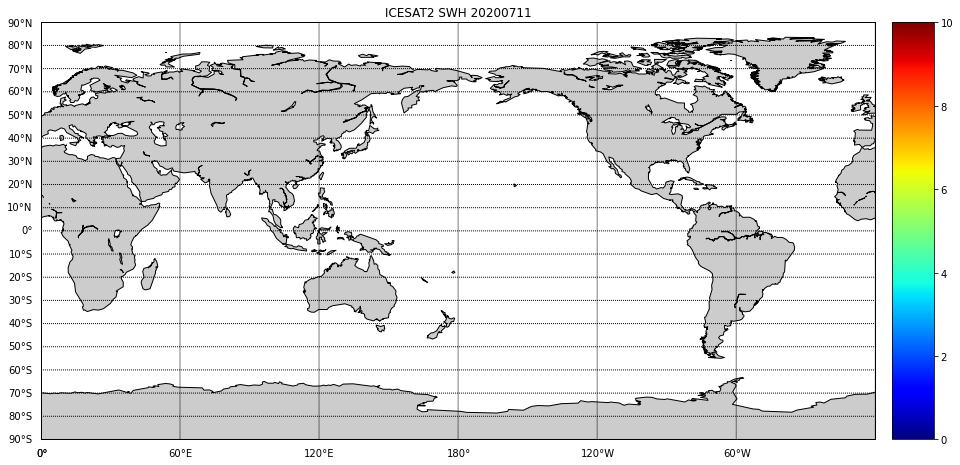

In [100]:
plt.figure(figsize=(16, 9))
is_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
# m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
is_xi, is_yi = is_m(is_x_map, is_y_map)

# Draw the scatterplot
h = is_m.pcolormesh(is_xi ,is_yi, data=hy_is_draw_diff_grid, cmap=plt.cm.jet,vmin=0, vmax=10, latlon=True)
is_m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

is_m.drawcoastlines()
is_m.fillcontinents()
is_m.drawmapboundary()
is_m.drawparallels(np.arange(-90., 120., 10.), labels=[1, 0, 0, 0])
is_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("ICESAT2 SWH 20200711")
plt.show()
plt.close()